In [27]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

**Visualize relationship between probability matrix and ground truth**

In [28]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta, sample_prob=1e-6)
    return P, R

beta = np.linspace(0, 2.5, 6)
results = [P_R_train(i) for i in beta]     

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kw

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_23244/3830447178.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


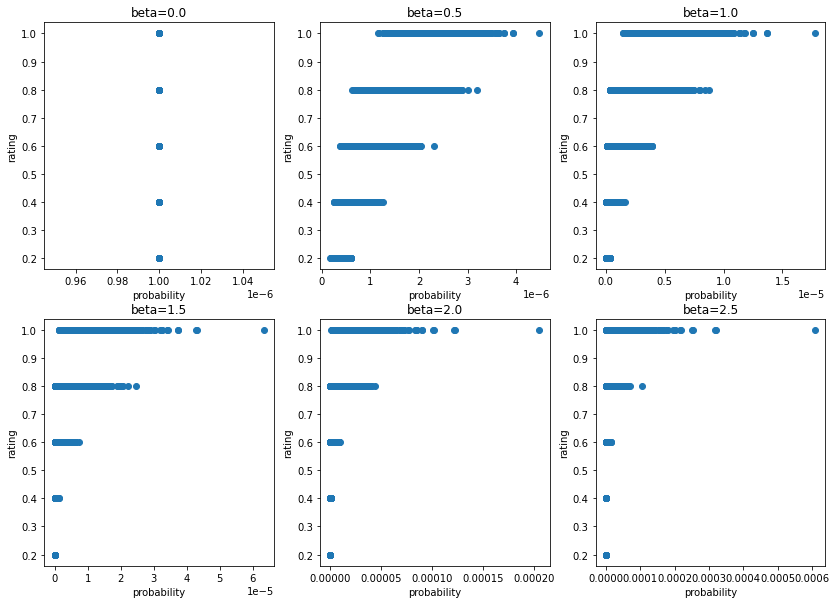

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    axs[i // 3, i % 3].scatter(results[i][0].flatten(), results[i][1].flatten(), linestyle='None')
    axs[i // 3, i % 3].set(xlabel='probability',
                           ylabel='rating', title=f'beta={beta[i]}')
fig.show()

**Experiment**

In [25]:
beta = np.linspace(0.1, 5, 5)
quantization = ['binary', 'onetothree', 'onetofive']
result = []

for i in range(len(quantization)):
    temp_result = []
    truth = generate_ground_truth_matrix(
    (1000, 1000), environment='ml-100k-v1')

    for j in range(len(beta)):
        users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
            truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
        train_df = to_dataframe(ratings)

        reader = Reader(rating_scale=(0, 1))
        data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
        trainset = data.build_full_trainset()

        algo = KNNBasic()
        algo.fit(trainset)

        test_df = generate_test_dataframe(R_no_noise)
        testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        temp_result.append(accuracy.rmse(predictions))

    result.append(temp_result)   


Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1575
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1910
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2338
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2942
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3199
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/py

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_23244/329955978.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


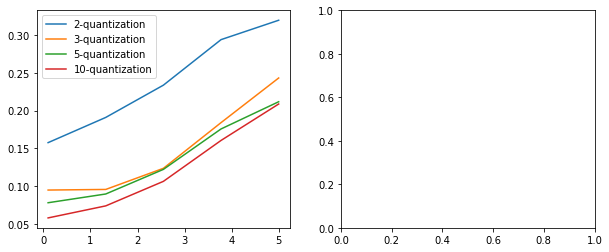

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(beta, result[0], label='2-quantization')
axs[0].plot(beta, result[1], label='3-quantization')
axs[0].plot(beta, result[2], label='5-quantization')
axs[0].legend()
fig.show()